# Project Overview

## Data Overview

Input X:
- A static station graph (connectivity between Indego stations)
- A temporal sequence of node features for each station, including:
- historical demand
- weather
- temporal context
- station attributes (location, capacity, amenities accessibility)

Output y:
- The next-hour demand for each station.

Table 1. Primary Data Sources
| Category                | Dataset Name              | File(s) Used                           | Provider / Link                                                                                                                                                              | Description                                                                                                                                                           |
| ----------------------- | ------------------------- | -------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Bike trips**          | Indego Trip Data          | indego-trips-2023–2025 (multiple CSVs) | [https://www.rideindego.com/about/data/](https://www.rideindego.com/about/data/)                                                                                             | Raw trip-level data (start/end time, station, direction, pass type, bike type). Used to aggregate to station–hour demand.                                             |
| **Station information** | Indego Stations Table     | indego-stations-2025-10-01.csv         | [https://www.rideindego.com/wp-content/uploads/2025/10/indego-stations-2025-10-01.csv](https://www.rideindego.com/wp-content/uploads/2025/10/indego-stations-2025-10-01.csv) | Provides station metadata: ID, name, coordinates, activation status. Used for spatial joins and amenities computation.                                                |
| **Station live feed**   | Indego All Stations (API) | — (used for reference)                 | [https://kiosks.bicycletransit.workers.dev/phl](https://kiosks.bicycletransit.workers.dev/phl)                                                                               | Live GeoJSON of all stations (coords, dock capacity). Not directly used in modeling but validates station locations.                                                  |
| **Weather**             | PHL ASOS Hourly Weather   | — (retrieved via pyiem)                | [https://pypi.org/project/pyiem/](https://pypi.org/project/pyiem/)                                                                                                           | Hourly weather observations from Philadelphia International Airport (PHL): temperature, precipitation, wind, humidity. Used as time-varying environmental predictors. |
| **Census**              | ACS demographic variables | — (retrieved via pytidycensus)         | [https://pypi.org/project/pytidycensus/](https://pypi.org/project/pytidycensus/)                                                                                             | Census variables (e.g., population, income). Currently optional—may be included in extended models or spatial context.                                                |


Table 2. Amenities Data Sources
| Amenity Category       | Dataset Name                     | File Used                      | Provider / Link                                                                                                                            | Description                                                                                              |
| ---------------------- | -------------------------------- | ------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------- |
| **Transit (Bus)**      | Bus Shelters                     | bus_transit_shelters.geojson   | [https://opendataphilly.org/datasets/bus-shelters/](https://opendataphilly.org/datasets/bus-shelters/)                                     | All bus shelters in Philadelphia. Used to compute number of bus stops within 500m/1000m of each station. |
| **Transit (Trolley)**  | SEPTA Trolley Stops              | Trolley_Stations.geojson       | [https://opendataphilly.org/datasets/septa-routes-stops-locations/](https://opendataphilly.org/datasets/septa-routes-stops-locations/)     | All trolley stops. Used for trolley access metrics.                                                      |
| **Transit (Rail)**     | SEPTA Regional Rail              | Regional_Rail_Stations.geojson | [https://opendataphilly.org/datasets/septa-routes-stops-locations/](https://opendataphilly.org/datasets/septa-routes-stops-locations/)     | Regional rail stations. Used to quantify rail-based accessibility.                                       |
| **Parks & Recreation** | Parks & Recreation Program Sites | PPR_Program_Sites.geojson      | [https://opendataphilly.org/datasets/parks-recreation-program-sites/](https://opendataphilly.org/datasets/parks-recreation-program-sites/) | Points representing parks, rec centers, and program sites. Used for greenspace availability.             |
| **Schools**            | Schools                          | Schools.geojson                | [https://opendataphilly.org/datasets/schools/](https://opendataphilly.org/datasets/schools/)                                               | Public/charter/private school locations. Used for educational environment indicators.                    |
| **Hospitals**          | Hospitals                        | Hospitals.geojson              | [https://opendataphilly.org/datasets/philadelphia-hospitals/](https://opendataphilly.org/datasets/philadelphia-hospitals/)                 | All licensed hospitals in Philadelphia. Used for distance-to-healthcare and accessibility measurements.  |


Table 3. Final Modeling Files (to be generated during preprocessing)
| File Name              | Description                                   | Generated In            |
| ---------------------- | --------------------------------------------- | ----------------------- |
| station_hourly.csv     | Hourly demand per station + temporal features | Trips preprocessing     |
| weather_hourly.csv     | Hourly weather aligned to Indego timeline     | Weather preprocessing   |
| amenities_features.csv | One row per station with spatial features     | Amenities preprocessing |
| model_input_train.csv  | Final training set (merged all features)      | Feature engineering     |
| model_input_test.csv   | Final test set                                | Feature engineering     |


## load data

In [3]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import os
from pytidycensus import set_census_api_key, get_acs

# Set Census API key
set_census_api_key("1b7ed44cc9ae2e98ab0c8ee5824e75a2d1e2dc36")

Census API key has been set for this session.


In [4]:
# -------------------------------------------------------------------
# Project paths
# Notebook is located at: Bike-Demand-Philly/notebooks/prelim/
# Base directory is two levels up.
# -------------------------------------------------------------------
BASE_DIR = Path("..").resolve().parent
DATA_RAW = BASE_DIR / "data" / "raw"

# -------------------------------------------------------------------
# Load amenities (GeoJSON datasets)
# -------------------------------------------------------------------
bus_shelters   = gpd.read_file(DATA_RAW / "bus_transit_shelters.geojson")
trolley_stops  = gpd.read_file(DATA_RAW / "Trolley_Stations.geojson")
rail_stations  = gpd.read_file(DATA_RAW / "Regional_Rail_Stations.geojson")
schools        = gpd.read_file(DATA_RAW / "Schools.geojson")
parks          = gpd.read_file(DATA_RAW / "PPR_Program_Sites.geojson")
hospitals      = gpd.read_file(DATA_RAW / "Hospitals.geojson")


In [5]:
print("bus shelters:", bus_shelters.shape, bus_shelters.crs, bus_shelters.geom_type.unique())
print("trolley stops:", trolley_stops.shape, trolley_stops.crs, trolley_stops.geom_type.unique())
print("rail stations:", rail_stations.shape, rail_stations.crs, rail_stations.geom_type.unique())
print("schools:", schools.shape, schools.crs, schools.geom_type.unique())
print("parks:", parks.shape, parks.crs, parks.geom_type.unique())
print("hospitals:", hospitals.shape, hospitals.crs, hospitals.geom_type.unique())

bus shelters: (487, 8) EPSG:4326 ['Point']
trolley stops: (60, 6) EPSG:4326 ['Point']
rail stations: (156, 7) EPSG:4326 ['Point']
schools: (495, 15) EPSG:4326 ['Point']
parks: (171, 11) EPSG:4326 ['Point']
hospitals: (36, 9) EPSG:4326 ['Point']


In [6]:
# -------------------------------------------------------------------
# Load Indego trips and split by year
# 2023 -> training, 2024 -> validation, 2025 -> test
# -------------------------------------------------------------------
train_files = sorted(DATA_RAW.glob("indego-trips-2023-q*.csv"))
val_files   = sorted(DATA_RAW.glob("indego-trips-2024-q*.csv"))
test_files  = sorted(DATA_RAW.glob("indego-trips-2025-q*.csv"))

trips_train = pd.concat([pd.read_csv(f, low_memory=False) for f in train_files], ignore_index=True)
trips_val   = pd.concat([pd.read_csv(f, low_memory=False) for f in val_files],   ignore_index=True)
trips_test  = pd.concat([pd.read_csv(f, low_memory=False) for f in test_files],  ignore_index=True)

# Drop rows with missing essential fields
trips_train = trips_train.dropna(subset=["start_time", "start_station", "start_lat", "start_lon"])
trips_val   = trips_val.dropna(subset=["start_time", "start_station", "start_lat", "start_lon"])
trips_test  = trips_test.dropna(subset=["start_time", "start_station", "start_lat", "start_lon"])

In [7]:
# philly boundary
philly_boundary = gpd.read_file("https://opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson")

philly_boundary = philly_boundary.to_crs(epsg=4326)

In [8]:
# -------------------------------------------------------------------
# weather
# -------------------------------------------------------------------
weather = pd.DataFrame()   # placeholder for hourly weather
census  = pd.DataFrame()   # placeholder for census variables

In [9]:
# -------------------------------------------------------------------
# Census data
# -------------------------------------------------------------------
acs_vars = [
    # population
    "B01001_001E", "B01001_002E", "B01001_026E",

    # age
    "B01001_020E", "B01001_021E", "B01001_022E",
    "B01001_023E",

    # race & ethnicity
    "B02001_002E", "B02001_003E", "B03003_003E",

    # education
    "B15003_017E", "B15003_022E", "B15003_023E", "B15003_025E",

    # income & poverty
    "B19013_001E", "B17001_002E"
]

rename_map = {
    # population
    "B01001_001E": "pop_total",
    "B01001_002E": "pop_male",
    "B01001_026E": "pop_female",

    # age groups
    "B01001_020E": "age_20_24",
    "B01001_021E": "age_25_29",
    "B01001_022E": "age_30_34",
    "B01001_023E": "age_35_44",

    # race & ethnicity
    "B02001_002E": "white",
    "B02001_003E": "black",
    "B03003_003E": "hispanic",

    # education
    "B15003_017E": "hs_grad",
    "B15003_022E": "bachelors",
    "B15003_023E": "masters",
    "B15003_025E": "doctorate",

    # income & poverty
    "B19013_001E": "median_income",
    "B17001_002E": "pop_poverty",
}



In [10]:
acs_raw = get_acs(
    geography="tract",
    variables= acs_vars,
    state="42",
    county="101",
    year=2023
)

Getting data from the 2019-2023 5-year ACS


## preprocess

In [13]:
# Clean up ACS dataframe
acs_raw = acs_raw[[c for c in acs_raw.columns if not c.endswith("_moe")]]
acs_raw = acs_raw.drop(columns=["NAME"])
acs_raw = acs_raw.rename(columns=rename_map)

In [14]:
acs_raw.columns

Index(['GEOID', 'pop_total', 'pop_male', 'pop_female', 'age_20_24',
       'age_25_29', 'age_30_34', 'age_35_44', 'white', 'black', 'hispanic',
       'hs_grad', 'bachelors', 'masters', 'doctorate', 'median_income',
       'pop_poverty', 'state', 'county', 'tract'],
      dtype='object')

In [15]:
# 1. Gender ratio
acs_raw["pct_male"]   = acs_raw["pop_male"] / acs_raw["pop_total"]
acs_raw["pct_female"] = acs_raw["pop_female"] / acs_raw["pop_total"]
# 2. Age structure
acs_raw["pct_age20_34"] = (
    acs_raw["age_20_24"] +
    acs_raw["age_25_29"] +
    acs_raw["age_30_34"]
) / acs_raw["pop_total"]

acs_raw["pct_age35_44"] = acs_raw["age_35_44"] / acs_raw["pop_total"]
# 3. Race & ethnicity structure
acs_raw["pct_white"]    = acs_raw["white"] / acs_raw["pop_total"]
acs_raw["pct_black"]    = acs_raw["black"] / acs_raw["pop_total"]
acs_raw["pct_hispanic"] = acs_raw["hispanic"] / acs_raw["pop_total"]
# 4. Education attainment
acs_raw["pct_higher_edu"] = (
    acs_raw["bachelors"] +
    acs_raw["masters"] +
    acs_raw["doctorate"]
) / acs_raw["pop_total"]
# 5. Poverty rate
acs_raw["pct_poverty"] = acs_raw["pop_poverty"] / acs_raw["pop_total"]

In [16]:
acs_raw.columns

Index(['GEOID', 'pop_total', 'pop_male', 'pop_female', 'age_20_24',
       'age_25_29', 'age_30_34', 'age_35_44', 'white', 'black', 'hispanic',
       'hs_grad', 'bachelors', 'masters', 'doctorate', 'median_income',
       'pop_poverty', 'state', 'county', 'tract', 'pct_male', 'pct_female',
       'pct_age20_34', 'pct_age35_44', 'pct_white', 'pct_black',
       'pct_hispanic', 'pct_higher_edu', 'pct_poverty'],
      dtype='object')

In [ ]:
acs = acs_raw[[
    "GEOID",
    "median_income",
    "pct_male",
    "pct_age20_34",
    "pct_age35_44",
    "pct_white",
    "pct_black",
    "pct_hispanic",
    "pct_higher_edu",
    "pct_poverty"
]].copy()


In [18]:
acs.head()
# -----------acs-----------

,GEOID,median_income,pct_male,pct_age20_34,pct_age35_44,pct_white,pct_black,pct_hispanic,pct_higher_edu,pct_poverty
0,42101000101,108438,0.345691,0.011022,0.021042,0.864228,0.023547,0.083667,0.781563,0.016032
1,42101000102,108203,0.583140,0.021818,0.016860,0.862479,0.025455,0.030744,0.657851,0.058182
2,42101000200,97256,0.556919,0.037128,0.010433,0.457195,0.081006,0.036514,0.388770,0.235655
3,42101000300,102330,0.442871,0.046506,0.012040,0.622993,0.116383,0.044618,0.541549,0.064684
4,42101000401,89663,0.475324,0.036752,0.050053,0.502975,0.211761,0.041302,0.591880,0.178509


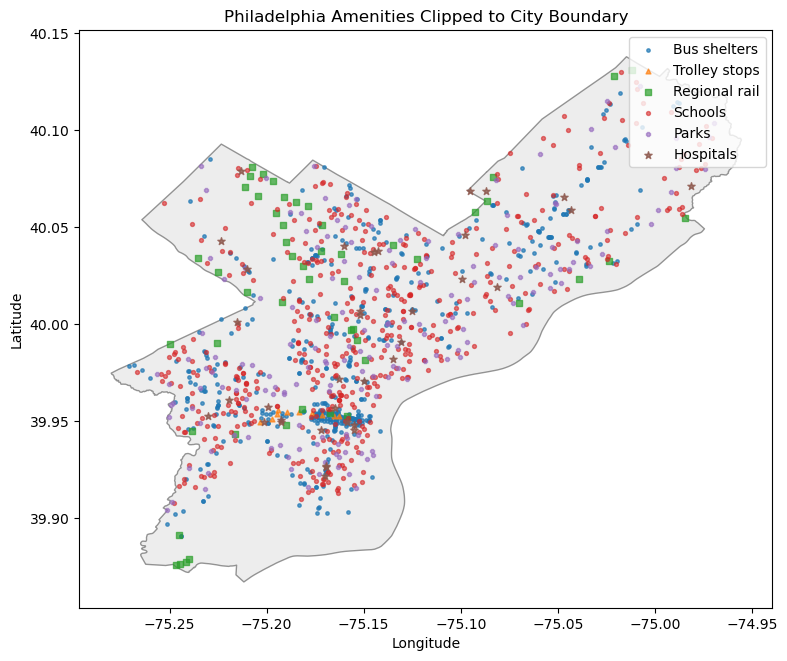

In [ ]:
# -------------------------------------------------------------------
# Amenities
# Basic scatter map of all amenities in one figure

bus_shelters_clipped   = gpd.clip(bus_shelters, philly_boundary)
trolley_stops_clipped  = gpd.clip(trolley_stops, philly_boundary)
rail_stations_clipped  = gpd.clip(rail_stations, philly_boundary)
schools_clipped        = gpd.clip(schools, philly_boundary)
parks_clipped          = gpd.clip(parks, philly_boundary)
hospitals_clipped      = gpd.clip(hospitals, philly_boundary)

fig, ax = plt.subplots(figsize=(8, 8))
philly_boundary.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.4)

bus_shelters_clipped.plot(ax=ax, markersize=6, alpha=0.7, label="Bus shelters")
trolley_stops_clipped.plot(ax=ax, markersize=12, alpha=0.7, marker="^", label="Trolley stops")
rail_stations_clipped.plot(ax=ax, markersize=20, alpha=0.7, marker="s", label="Regional rail")
schools_clipped.plot(ax=ax, markersize=8, alpha=0.6, label="Schools")
parks_clipped.plot(ax=ax, markersize=10, alpha=0.6, marker="P", label="Parks")
hospitals_clipped.plot(ax=ax, markersize=30, alpha=0.8, marker="*", label="Hospitals")

ax.set_title("Philadelphia Amenities Clipped to City Boundary")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [21]:
# -------------------------------------------------------------------
# Trip GeoDataFrames
# Convert train/val/test trips to GeoDataFrames (using start station coordinates)
gdf_train = gpd.GeoDataFrame(
    trips_train,
    geometry=gpd.points_from_xy(trips_train.start_lon, trips_train.start_lat),
    crs="EPSG:4326"
)

gdf_val = gpd.GeoDataFrame(
    trips_val,
    geometry=gpd.points_from_xy(trips_val.start_lon, trips_val.start_lat),
    crs="EPSG:4326"
)

gdf_test = gpd.GeoDataFrame(
    trips_test,
    geometry=gpd.points_from_xy(trips_test.start_lon, trips_test.start_lat),
    crs="EPSG:4326"
)

gdf_train = gpd.clip(gdf_train, philly_boundary)
gdf_val   = gpd.clip(gdf_val, philly_boundary)
gdf_test  = gpd.clip(gdf_test, philly_boundary)

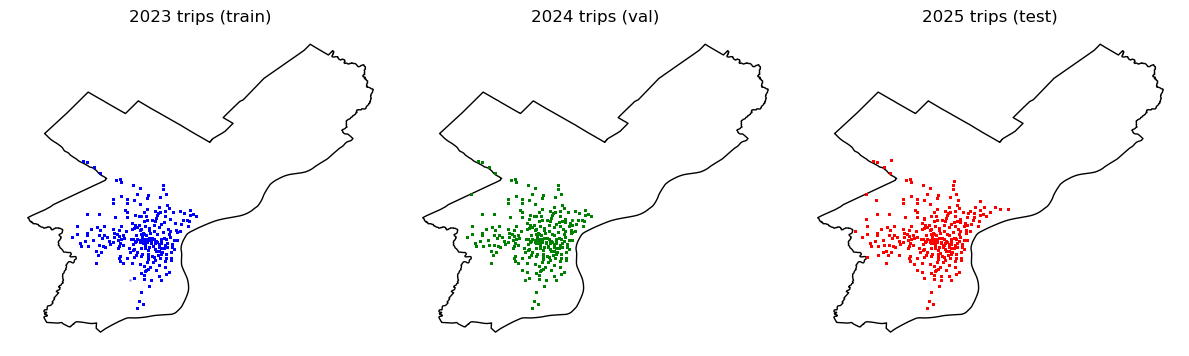

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

layers = [
    ("2023 trips (train)", gdf_train, "blue"),
    ("2024 trips (val)",   gdf_val,   "green"),
    ("2025 trips (test)",  gdf_test,  "red"),
]

for ax, (title, gdf, color) in zip(axes, layers):
    philly_boundary.plot(ax=ax, color="white", edgecolor="black")
    gdf.plot(ax=ax, markersize=1, alpha=0.3, color=color)
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## feature engineering

## model - baseline
linear regression